# Implementation of REINFORCE: Monte-Carlo Policy Gradient Control (episodic) on MountainCar-v0

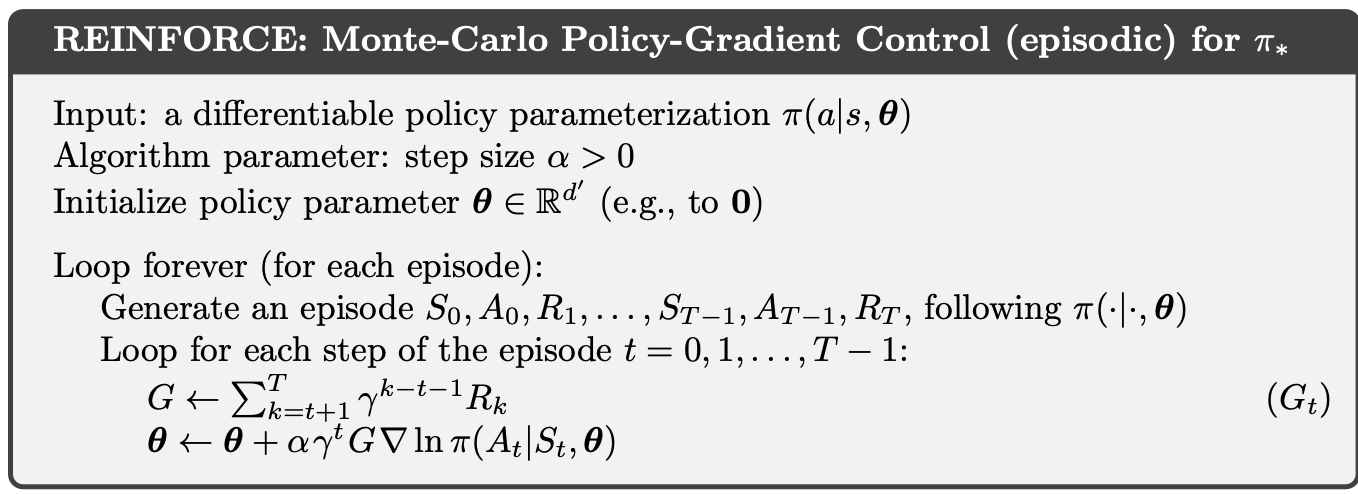



In [253]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [254]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [255]:
class TileCodingApprox:
    def __init__(self, stateSpaceLowBoundary, stateSpaceHighBoundary, nActions, learningRate, nTilings):
        assert len(stateSpaceLowBoundary) == len(stateSpaceHighBoundary)
        self._nDimensions = len(stateSpaceLowBoundary)
        self._learningRate = learningRate / nTilings
        self._nTilings = nTilings
        self._scale = self._nTilings / (stateSpaceHighBoundary - stateSpaceLowBoundary)

        # If we want 8 tilings in a 2D Space with 3 actions then the total tiles would be (8+1)*(8+1)*8*3
        self._totalTiles = ((nTilings + 1)**self._nDimensions) * nTilings * nActions
        self._iht = IHT(self._totalTiles)
        self._theta = np.zeros(self._totalTiles*nActions)
        self._theta[0:self._totalTiles] = 1
        self._theta[self._totalTiles*2:] = 1
        self._nActions = nActions

    def x(self, state, action):
        # Constructing the Feature Vector
        scaledState = np.multiply(self._scale, state)
        activeTiles = tiles(self._iht, self._nTilings, scaledState)
        featureVector = np.zeros(self._totalTiles)
        featureVector[activeTiles] = 1

        featureVectorScaled = np.zeros(self._totalTiles*self._nActions)
        featureVectorScaled[self._totalTiles*action:self._totalTiles*(action+1)] = featureVector
        return featureVectorScaled

    def h(self, state, action): 
        # Calculating the Preference h(s,a,theta)
        return np.dot(self._theta, self.x(state, action))

    def softmax(self, x):
        # For some reason doing this doesn't work and cause values to become large. Had to utilize this long way 
        # ex = np.exp(x-np.max(x))
        # return ex / np.sum(ex)
        x = np.array(x)
        maxVal = np.max(x)
        x = x - maxVal
        expVal = np.exp(x)
        sumExpVal = np.sum(expVal)
        return expVal / sumExpVal
    
    def policy(self, state):
        hVector = [self.h(state, action) for action in range(self._nActions)]
        hVector = self.softmax(hVector)
        return hVector
    
    def update(self, state, action, discountedReturn):
        probVector = self.policy(state)
        sumB = [probVector[b]*self.x(state, b) for b in range(self._nActions)]
        sumB = np.sum(sumB)
        gradient = self.x(state, action) - sumB
        self._theta += self._learningRate * discountedReturn * gradient

## Policy

In [257]:
# Parameters
env = gym.make("MountainCar-v0", max_episode_steps=100000)
nActions = env.action_space.n 
alpha = 0.01
gamma = 1.0
maxEpisodes = 500

# Input
tiles2 = TileCodingApprox(env.observation_space.low, env.observation_space.high, nActions, 2**-12, 8)

rewards = []
# Initialization
for episode in range(maxEpisodes):
    initialState, _ = env.reset()
    initialAction = np.random.choice(nActions, p=tiles2.policy(initialState))

    done = False
    trajectory = []
    totalReward = 0
    while not done:
        nextState, reward, done, _, _ = env.step(initialAction)
        trajectory.append([initialState, initialAction, reward])
        totalReward += reward
        initialState = nextState
        initialAction = np.random.choice(nActions, p=tiles2.policy(nextState))
    rewards.append(totalReward)
    for t in range(len(trajectory)):
        G = 0
        for k in range(t+1, len(trajectory)):
            G += (gamma**(k-t-1)) * trajectory[k][2]
        tiles2.update(trajectory[k][0],trajectory[k][1],(gamma**t)*G)
        
env.close()

[4.99916148e-01 1.67703185e-04 4.99916148e-01]
[5.95197253e-01 1.99666434e-04 4.04603081e-01]
[6.83737824e-01 2.29368487e-04 3.16032808e-01]
[7.60634265e-01 2.55164370e-04 2.39110570e-01]
[8.23597412e-01 2.76286152e-04 1.76126302e-01]
[8.72715792e-01 2.92763533e-04 1.26991444e-01]
[9.09609347e-01 3.05139942e-04 9.00855126e-02]
[9.36541884e-01 3.14174802e-04 6.31439412e-02]
[9.55797910e-01 3.20634479e-04 4.38814558e-02]
[9.69362598e-01 3.25184924e-04 3.03122175e-02]
[9.78819223e-01 3.28357269e-04 2.08524202e-02]
[9.85364721e-01 3.30553039e-04 1.43047260e-02]
[9.89873110e-01 3.32065435e-04 9.79482424e-03]
[9.92968157e-01 3.33103707e-04 6.69873900e-03]
[9.95088288e-01 3.33814932e-04 4.57789675e-03]
[9.96538531e-01 3.34301434e-04 3.12716752e-03]
[9.97529660e-01 3.34633921e-04 2.13570650e-03]
[9.98206657e-01 3.34861028e-04 1.45848157e-03]
[9.98668953e-01 3.35016111e-04 9.96030853e-04]
[9.98984599e-01 3.35121999e-04 6.80278623e-04]
[9.99200116e-01 3.35194297e-04 4.64689997e-04]
[9.99347277e-

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1040cad60>>
Traceback (most recent call last):
  File "/Users/jasonchen/anaconda3/envs/rl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[4.99916148e-01 1.67703185e-04 4.99916148e-01]
[9.98657965e-01 3.35012425e-04 1.00702283e-03]
[9.99663633e-01 3.35349790e-04 1.01672853e-06]
[9.99664649e-01 3.35350130e-04 1.02574652e-09]
[9.99664650e-01 3.35350130e-04 1.03509613e-12]
[9.9966465e-01 3.3535013e-04 1.0447860e-15]
[9.99664650e-01 3.35350130e-04 1.05482408e-18]
[9.99664650e-01 3.35350130e-04 1.06521863e-21]
[9.99664650e-01 3.35350130e-04 1.07597827e-24]
[9.99664650e-01 3.35350130e-04 1.08711196e-27]
[9.99664650e-01 3.35350130e-04 1.09862905e-30]
[9.99664650e-01 3.35350130e-04 1.11053925e-33]
[9.99664650e-01 3.35350130e-04 1.12285267e-36]
[9.99664650e-01 3.35350130e-04 1.13557982e-39]
[9.99664650e-01 3.35350130e-04 1.14873165e-42]
[9.99664650e-01 3.35350130e-04 1.16231953e-45]
[9.9966465e-01 3.3535013e-04 1.1763553e-48]
[9.99664650e-01 3.35350130e-04 1.19085126e-51]
[9.99664650e-01 3.35350130e-04 1.20582021e-54]
[9.99664650e-01 3.35350130e-04 1.22127544e-57]
[9.99664650e-01 3.35350130e-04 1.23723078e-60]
[9.99664650e-01 3.3